# Imports

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Pre-Processing

In [2]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "call"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Columns to numeric conversion: choose columns based on option type
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d', '[C_BID]', '[C_ASK]']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=essential_cols, inplace=True)

# Calculate mid-price based on option type
if option_type == 'call':
    df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
else:
    df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

# Drop rows with missing essential data (dynamically chosen based on option type)
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
if option_type == 'call':
    essential_cols.append('CALL_EQUI_PRICE')
else:
    essential_cols.append('PUT_EQUI_PRICE')
df.dropna(subset=essential_cols, inplace=True)

# Prepare option data based on the option type
if option_type == 'call':
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', 'CALL_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_calls_data.csv'
    model_file = 'call-mlp1.h5'
else:
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', 'PUT_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_puts_data.csv'
    model_file = 'put-mlp1.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

print(option_df.sample(10))

         underlying_price  strike_price  hist_volatility    delta    gamma  \
1067249            131.84        0.1900         0.351839  0.02625  0.00268   
1172498            175.77        0.1675         0.322268  0.79138  0.02832   
522449             190.04        0.2250         0.312632  0.01646  0.00280   
1360656            155.35        0.1450         0.246784  0.79194  0.01892   
586738             185.77        0.1500         0.119764  0.90953  0.00363   
1167497            160.03        0.0950         0.201600  0.92995  0.00209   
1191167            166.28        0.1700         0.238177  0.42833  0.02466   
984062             462.82        0.5800         0.488715  0.00056  0.00006   
1037990            148.61        0.1460         0.488307  0.69042  0.06570   
593013             185.11        0.1800         0.122481  0.57199  0.00781   

            vega    theta      rho  equilibrium_price  time_to_expiry  
1067249  0.04671 -0.00611  0.01115              0.220        0.325918

# Hyperparameters

In [3]:
# Hyperparameters
n_units_per_layer = [256, 32, 1]
layers = 3
n_batch = 1024
n_epochs = 50

# Building model

In [4]:
# Prepare data for modeling
X = option_df[['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'time_to_expiry']]
y = option_df['equilibrium_price']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model 
model = Sequential()


# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer without ativation
model.add(Dense(n_units_per_layer[0], input_shape=(X_train_scaled.shape[1],)))
model.add(Activation('relu'))

# Define Keras MLP model using LeakyReLU in subsequent layers
for i in range(1, layers - 1):
    model.add(Dense(n_units_per_layer[i]))
    model.add(Activation('relu'))

# Add last layer
model.add(Dense(n_units_per_layer[-1]))
model.add(Activation('relu'))

# Learning rate scheduling
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

early_stop = EarlyStopping(
    monitor='val_loss',       # what to monitor
    patience=5,               # how many epochs to wait before stopping
    restore_best_weights=True,  # restores weights from best epoch
    verbose=1
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

c:\GitHub Repos\CS-4641-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [5]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback, early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae}")

# Save the model
model.save(model_file)

Epoch 1/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1050.8749 - mae: 14.3836 - val_loss: 3.6946 - val_mae: 1.1892 - learning_rate: 0.0010
Epoch 2/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1642 - mae: 1.0462 - val_loss: 1.9606 - val_mae: 0.7368 - learning_rate: 0.0010
Epoch 3/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9662 - mae: 0.6897 - val_loss: 1.3286 - val_mae: 0.5587 - learning_rate: 0.0010
Epoch 4/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2700 - mae: 0.5364 - val_loss: 0.9893 - val_mae: 0.4488 - learning_rate: 0.0010
Epoch 5/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0260 - mae: 0.4301 - val_loss: 0.8307 - val_mae: 0.3783 - learning_rate: 0.0010
Epoch 6/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9225 - mae: 0.3678 - val_loss: 0.7168 - val_mae: 0.3305 - learning_rate: 0.0010
Epoch 7/50
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9339 - mae: 0.3401 - val_loss: 0.6822 - val_mae: 0.3172 - learning_rate: 0.0010
Ep

Test MAE: 0.2416796088218689


# Plot the loss

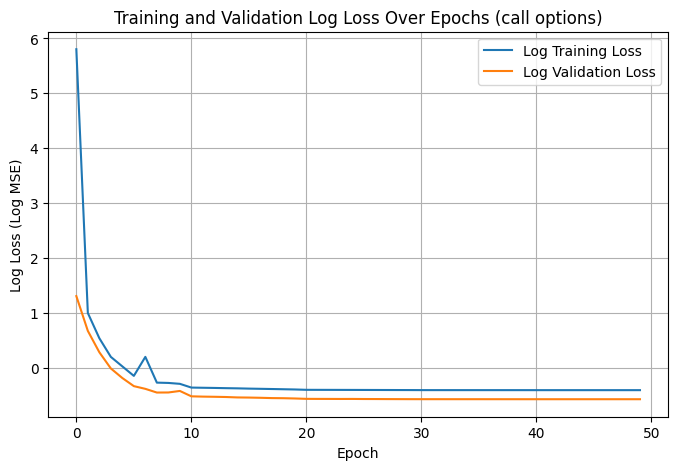

In [6]:
# Plot training and validation loss
plt.figure(figsize=(8,5))

eps = 1e-10  # tiny number to avoid log(0)
plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.show()

# Plot results

9685/9685 ━━━━━━━━━━━━━━━━━━━━ 5s 534us/step


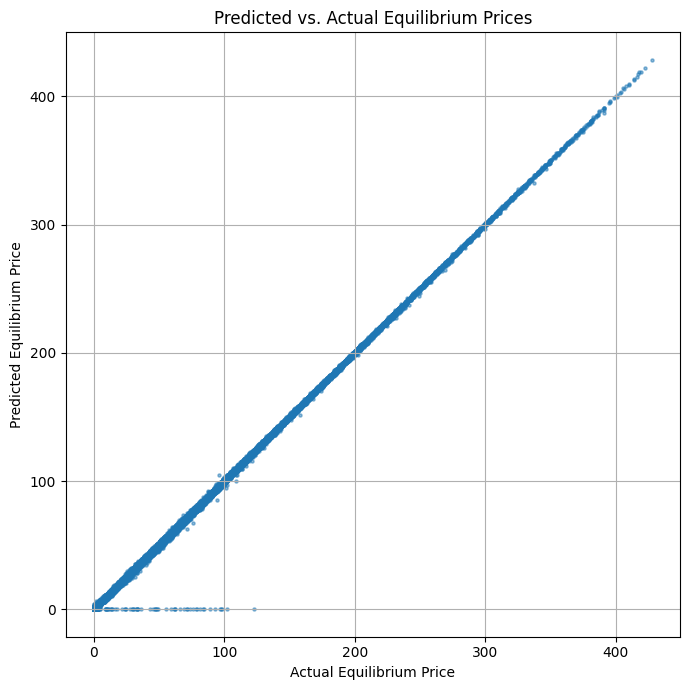

In [7]:
loaded_model = load_model(model_file)

# Predict on test set
y_pred = model.predict(X_test_scaled).flatten()

# Align y_test to numpy array with matching shape
y_test_array = y_test.to_numpy().flatten()

# Plot predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(y_test_array, y_pred, s=5, alpha=0.5)
plt.xlabel('Actual Equilibrium Price')
plt.ylabel('Predicted Equilibrium Price')
plt.title('Predicted vs. Actual Equilibrium Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Test random entries

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Entry 1129339 - Predicted price: 0.00, Actual price: 0.01
Entry 1179057 - Predicted price: 19.33, Actual price: 19.70
Entry 1371370 - Predicted price: 2.79, Actual price: 2.54
Entry 745853 - Predicted price: 0.92, Actual price: 1.17
Entry 1034964 - Predicted price: 1.60, Actual price: 1.46
Entry 1519102 - Predicted price: 66.14, Actual price: 66.55
Entry 1434938 - Predicted price: 10.08, Actual price: 9.93
Entry 1164729 - Predicted price: 11.94, Actual price: 12.88
Entry 1305874 - Predicted price: 2.73, Actual price: 2.45
Entry 893064 - Predicted price: 16.64, Actual price: 16.75
9685/9685 ━━━━━━━━━━━━━━━━━━━━ 6s 566us/step


C:\Users\Adam Khalil\AppData\Local\Temp\ipykernel_18304\3841605036.py:18: RuntimeWarning: divide by zero encountered in divide
  percent_error = 100 * diff / y_true
C:\Users\Adam Khalil\AppData\Local\Temp\ipykernel_18304\3841605036.py:18: RuntimeWarning: invalid value encountered in divide
  percent_error = 100 * diff / y_true



--- MLP Error Metrics ---
Mean Error: -0.0196
Median Error: -0.0110
Standard Deviation of Error: 0.8558
Mean Absolute Error (MAE): 0.2417
Root Mean Squared Error (RMSE): 0.8560
Mean Absolute Percentage Error (MAPE): nan%
Max Error: 9.0808
Min Error: -122.5000
R² Score: 0.9997


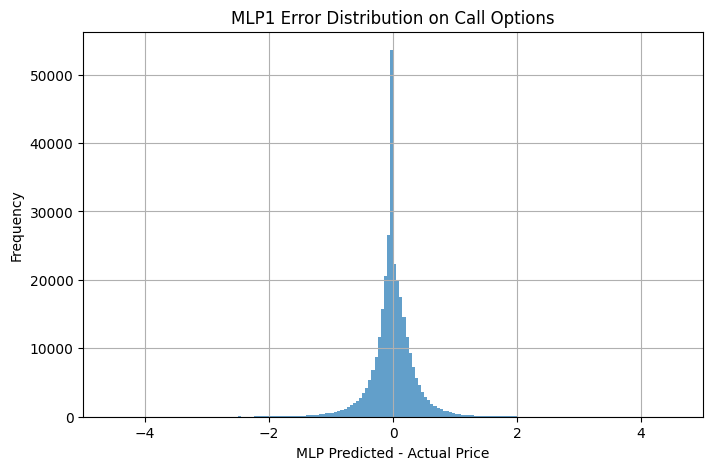

In [12]:
# Test 10 random entries
loaded_model = load_model(model_file)
sample_entries = X.sample(10)
sample_scaled = scaler.transform(sample_entries)
predictions = loaded_model.predict(sample_scaled)

for i, idx in enumerate(sample_entries.index):
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {y.loc[idx]:.2f}")

# ---- Full Test Set Error Analysis ----
X_test_scaled = scaler.transform(X_test)
y_pred = loaded_model.predict(X_test_scaled).flatten()
y_true = y_test.values

# Compute differences and errors
diff = y_pred - y_true
abs_error = np.abs(diff)
percent_error = 100 * diff / y_true
abs_percent_error = np.abs(percent_error)

# Metrics
mean_diff = np.mean(diff)
median_diff = np.median(diff)
std_diff = np.std(diff)
mae = abs_error.mean()
rmse = np.sqrt(np.mean(diff**2))
mape = abs_percent_error.mean()
max_diff = diff.max()
min_diff = diff.min()

# Drop NaNs for R² calculation
valid = ~np.isnan(y_pred) & ~np.isnan(y_true)
r2 = r2_score(y_true[valid], y_pred[valid])

# Print metrics
print("\n--- MLP Error Metrics ---")
print(f"Mean Error: {mean_diff:.4f}")
print(f"Median Error: {median_diff:.4f}")
print(f"Standard Deviation of Error: {std_diff:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Max Error: {max_diff:.4f}")
print(f"Min Error: {min_diff:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot histogram of errors
bins = np.arange(-5, 5, 0.05)

plt.figure(figsize=(8, 5))
plt.hist(diff, bins=bins, alpha=0.7)
plt.xlabel("MLP Predicted - Actual Price")
plt.ylabel("Frequency")
plt.title("MLP1 Error Distribution on Call Options")
plt.xlim([-5, 5])
plt.grid(True)
plt.show()